In [ ]:
!ls
from google.colab import drive
drive.mount('/content/gdrive')


sample_data
Mounted at /content/gdrive


In [ ]:
cd 'gdrive/My Drive/523'

/content/gdrive/My Drive/523


Import Statements

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tqdm import tqdm
from os import sys, path 
import pandas as pd
import keras 
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt


Instructions for updating:
non-resource variables are not supported in the long term


#1 Imputation using GAIN 

Created a wrapper around the GAIN implementation by the 

Authors: Jinsung Yoon, James Jordon, Mihaela van der Schaar
Paper: Jinsung Yoon, James Jordon, Mihaela van der Schaar, "GAIN: Missing Data Imputation using Generative Adversarial Nets," International Conference on Machine Learning (ICML), 2018.
Paper Link: http://proceedings.mlr.press/v80/yoon18a/yoon18a.pdf
https://github.com/jsyoon0823/GAIN

**GAN**
GANs contain two networks: a generator network, which learns to generate datapoints
from random latent variables, and a discriminator network, which learns to differentiate
between random outputs from the generator and the true datapoints in the training set.
As the two networks have opposing goals, the generator eventually learns to generate outputs
that are similar to the true datapoints to better fool the discriminator. The generator then
defines a distribution over the data, which can be sampled from

## 1.1 Gain Architechture 

![alt text](https://d3i71xaburhd42.cloudfront.net/a89f0a78f86077864e108a1bd2c4e670c85907f8/2-Figure1-1.png)




##1.2 Gain Algorithms Wrapper Class 
Performs preprocessing, normalization , test train split, training 

Initialization for mini batch size, missing rate, hint rate, alpha and train rate

In [ ]:

class GAIN():
    # defining hyperparameters 
    def __init__(self, minibatch_size, missing_vals_percent, p_hint, alpha, train_rate):
        self.mb_size= minibatch_size
        self.p_miss = missing_vals_percent
        self.p_hint = p_hint
        self.alpha = alpha
        self.train_rate = train_rate
        self.H_Dim1 = None
        self.H_Dim2 = None
        self.missing_indices = []
        print('Initialised GAIN object')

Functions for normalize, missingness introduction, train test split

In [ ]:
class GAIN(GAIN):
    def normalize(self, data, dimension):
            Min_Val = np.zeros(dimension)
            Max_Val = np.zeros(dimension)
            for i in range(dimension):
                Min_Val[i] = np.min(data[:,i])
                data[:,i] = data[:,i] - np.min(data[:,i])
                Max_Val[i] = np.max(data[:,i])
                data[:,i] = data[:,i] / (np.max(data[:,i]) + 1e-6)  
            print('Norm Done')              
            return data   
    
    def introduce_missingness(self, Dim, No, Data):
            p_miss_vec = self.p_miss * np.ones((Dim,1))
            Missing = np.zeros((No, Dim))
            for i in range(Dim):
                A = np.random.uniform(0., 1., size = [len(Data),])
                B = A > p_miss_vec[i]
                Missing[:,i] = 1.*B
            print('Missing Done')
            return Missing
    
    def train_test_split(self, No, Data, Missing):
        idx = np.random.permutation(No)
        Train_No = int(No * self.train_rate)
        Test_No = No - Train_No
        trainX = Data[idx[:Train_No],:]
        testX = Data[idx[Train_No:],:]
        trainM = Missing[idx[:Train_No],:]
        testM = Missing[idx[Train_No:],:]
        print('Train/Test Done')
        return trainX, testX, trainM, testM, Train_No, Test_No

Implementing gain architecture, generator, discriminator

In [ ]:
class GAIN(GAIN):
    def gain_architecture(self, Dim):
            X = tf.placeholder(tf.float32, shape = [None, Dim])
            M = tf.placeholder(tf.float32, shape = [None, Dim])
            H = tf.placeholder(tf.float32, shape = [None, Dim])
            New_X = tf.placeholder(tf.float32, shape = [None, Dim])
            # Data + Hint as inputs
            D_W1 = tf.Variable(self.xavier_init([Dim*2, self.H_Dim1]))     
            D_b1 = tf.Variable(tf.zeros(shape = [ self.H_Dim1]))
            D_W2 = tf.Variable(self.xavier_init([self.H_Dim1, self.H_Dim2]))
            D_b2 = tf.Variable(tf.zeros(shape = [self.H_Dim2]))
            D_W3 = tf.Variable(self.xavier_init([self.H_Dim2, Dim]))
             # Output is multi-variate
            D_b3 = tf.Variable(tf.zeros(shape = [Dim]))      
            theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]
            # Data + Mask as inputs (Random Noises are in Missing Components)
            G_W1 = tf.Variable(self.xavier_init([Dim*2, self.H_Dim1]))     
            G_b1 = tf.Variable(tf.zeros(shape = [self.H_Dim1]))
            G_W2 = tf.Variable(self.xavier_init([self.H_Dim1, self.H_Dim2]))
            G_b2 = tf.Variable(tf.zeros(shape = [self.H_Dim2]))
            G_W3 = tf.Variable(self.xavier_init([self.H_Dim2, Dim]))
            G_b3 = tf.Variable(tf.zeros(shape = [Dim]))
            theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]
            print('Gain Arch Done')
            return theta_D, theta_G, X, M, H, New_X
    @staticmethod
    def generator(new_x, m, G_W1, G_W2, G_W3, G_b1, G_b2, G_b3):
        inputs = tf.concat(axis = 1, values = [new_x,m])  # Mask + Data Concatenate
        G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
        G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)   
        G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3) # [0,1] normalized Output
        print('Gen Samp Done')
        return G_prob         
    @staticmethod
    def discriminator(new_x, h, D_W1, D_W2, D_W3, D_b1, D_b2, D_b3):
        inputs = tf.concat(axis = 1, values = [new_x,h])  # Hint + Data Concatenate
        D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)  
        D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
        D_logit = tf.matmul(D_h2, D_W3) + D_b3
        D_prob = tf.nn.sigmoid(D_logit)  # [0,1] Probability Output
        print('Disc Sample Done')
        return D_prob



 Preprocessing input data : normalize, load, get dimensions

In [ ]:
class GAIN(GAIN):
    def preprocess(self, inputData):
            Data = np.loadtxt(inputData, delimiter=",",skiprows=1)
            #Data = np.loadtxt(inputData, delimiter=",")
            No = len(Data)
            Dim = len(Data[0,:])
            self.H_Dim1 = Dim
            self.H_Dim2 = Dim
            normalized_data = self.normalize(Data, Dim)
            print('Preprocess Done')
            return normalized_data, No, Dim

Static methods: xavier initialization, sample generation 

In [ ]:
class GAIN(GAIN):
    @staticmethod
    def xavier_init(size):
        in_dim = size[0]
        xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
        return tf.random_normal(shape = size, stddev = xavier_stddev)
    @staticmethod
    def sample_M(m, n, p):
        A = np.random.uniform(0., 1., size = [m, n])
        B = A > p
        C = 1.*B
        return C    
    @staticmethod
    def sample_Z(m, n):
        return np.random.uniform(0., 0.01, size = [m, n])    
    @staticmethod    
    def sample_idx(m, n):
         A = np.random.permutation(m)
         idx = A[:n]
         return idx

Train function

In [ ]:

class GAIN(GAIN):    
    def train(self, normalized_data, No, Dim):
        missing_matrix  = self.introduce_missingness(Dim, No, normalized_data)

        

        trainX, testX, trainM, testM, Train_No, Test_No= self.train_test_split(No, normalized_data, missing_matrix)


        theta_D, theta_G, X, M, H, New_X = self.gain_architecture(Dim)
        G_sample = self.generator(New_X, M, theta_G[0],theta_G[1], theta_G[2], theta_G[3], theta_G[4], theta_G[5])
        Hat_New_X = New_X * M + G_sample * (1-M)
        D_prob = self.discriminator(Hat_New_X, H, theta_D[0], theta_D[1], theta_D[2], theta_D[3],theta_D[4],theta_D[5])
        D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) 
        G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
        MSE_train_loss = tf.reduce_mean((M * New_X - M * G_sample)**2) / tf.reduce_mean(M)
        
        D_loss = D_loss1
        G_loss = G_loss1 + gain_obj.alpha * MSE_train_loss
        MSE_test_loss = tf.reduce_mean(((1-M) * X - (1-M)*G_sample)**2) / tf.reduce_mean(1-M)
        
        D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
        G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        train_loss_1 = []
        test_loss_1 = []
        for it in tqdm(range(5000)):    
            mb_idx = gain_obj.sample_idx(Train_No, gain_obj.mb_size)
            X_mb = trainX[mb_idx,:]      
            Z_mb = gain_obj.sample_Z(gain_obj.mb_size, Dim) 
            M_mb = trainM[mb_idx,:]  
            H_mb1 = gain_obj.sample_M(gain_obj.mb_size, Dim, 1-gain_obj.p_hint)
            H_mb = M_mb * H_mb1    
            New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce    
            _, D_loss_curr = sess.run([D_solver, D_loss1], feed_dict = {M: M_mb, New_X: New_X_mb, H: H_mb})
            _, G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr = sess.run([G_solver, G_loss1, MSE_train_loss, MSE_test_loss],
                                                                           feed_dict = {X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb})
            if it % 100 == 0:
                print('Iter: {}'.format(it))
                train_loss_1.append(np.sqrt(MSE_train_loss_curr))
                test_loss_1.append(np.sqrt(MSE_test_loss_curr))
                print('Train_loss: {:.4}'.format(np.sqrt(MSE_train_loss_curr)))
                print('Test_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr)))
                print()
        return Test_No, testM, testX, MSE_test_loss, G_sample, sess, X, M, New_X, train_loss_1, test_loss_1, trainX

Test functions, impute, evaluate. [Evaluate results are provided in test]

In [ ]:
class GAIN(GAIN):
    def test(self, Test_No, testM, testX, MSE_test_loss, G_sample, sess, X, M, New_X):
        Z_mb = gain_obj.sample_Z(Test_No, Dim) 
        M_mb = testM
        X_mb = testX
        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
        MSE_final, Sample = sess.run([MSE_test_loss, G_sample], feed_dict = {X: testX, M: testM, New_X: New_X_mb})
        print('Final Test RMSE: ' + str(np.sqrt(MSE_final)))
        return New_X_mb, X_mb
        
    def impute(self, trained_model, input):
        pass
    
    def evaluate(self, trained_model, input):
        pass

## 1.3 GAIN on Cancer Dataset

In [ ]:
INPUT_FILE = '/content/gdrive/My Drive/523/breast.csv'
df_1 = pd.read_csv(INPUT_FILE)
df_1.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,1,1,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,0.7859,3.0940,48.31,0.006240,0.01484,0.02813,0.010930,0.01397,0.002461,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019,NaN
1,2,2,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,0.4690,1.1150,12.68,0.004731,0.01345,0.01652,0.005905,0.01619,0.002081,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915,NaN
2,3,2,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,0.9480,2.1710,24.87,0.005332,0.02115,0.01536,0.011870,0.01522,0.002815,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472,NaN
3,4,2,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,0.9050,0.9975,11.36,0.002887,0.01285,0.01613,0.007308,0.01870,0.001972,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834,NaN
4,5,1,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0.2871,0.8937,1.8970,24.25,0.006532,0.02336,0.02905,0.012150,0.01743,0.003643,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790,NaN


In [ ]:
mini_batch_size = 50
percentage_missing_values = 0.1
hint_perc = 0.9
alpha = 1
# Train test split 
train_rate = 0.80

gain_obj = GAIN(mini_batch_size,percentage_missing_values, hint_perc,alpha, train_rate)
normalized_data, No_rows, Dim= gain_obj.preprocess('/content/gdrive/My Drive/523/data/heart.csv')

Initialised GAIN object
Norm Done
Preprocess Done


In [ ]:
Test_No, testM, testX, MSE_test_loss, G_sample, sess, X, M, New_X, train_loss_1, test_loss_1, trainX = gain_obj.train(normalized_data, No_rows, Dim)

Missing Done
Train/Test Done
Gain Arch Done
Gen Samp Done
Disc Sample Done


  1%|          | 49/5000 [00:00<09:02,  9.12it/s]

Iter: 0
Train_loss: 0.6192
Test_loss: 0.6453



  4%|▎         | 179/5000 [00:00<03:08, 25.55it/s]

Iter: 100
Train_loss: 0.5194
Test_loss: 0.5503



  5%|▌         | 268/5000 [00:00<01:36, 49.19it/s]

Iter: 200
Train_loss: 0.4531
Test_loss: 0.502



  7%|▋         | 357/5000 [00:00<00:51, 89.96it/s]

Iter: 300
Train_loss: 0.4013
Test_loss: 0.4943



 10%|▉         | 491/5000 [00:01<00:23, 189.32it/s]

Iter: 400
Train_loss: 0.3813
Test_loss: 0.4753



 12%|█▏        | 585/5000 [00:01<00:16, 271.50it/s]

Iter: 500
Train_loss: 0.3549
Test_loss: 0.4546



 14%|█▎        | 678/5000 [00:01<00:12, 341.77it/s]

Iter: 600
Train_loss: 0.3504
Test_loss: 0.4655



 15%|█▌        | 773/5000 [00:01<00:10, 384.74it/s]

Iter: 700
Train_loss: 0.343
Test_loss: 0.3976



 17%|█▋        | 867/5000 [00:02<00:10, 411.20it/s]

Iter: 800
Train_loss: 0.3376
Test_loss: 0.447



 19%|█▉        | 963/5000 [00:02<00:09, 441.92it/s]

Iter: 900
Train_loss: 0.3278
Test_loss: 0.4788



 21%|██        | 1058/5000 [00:02<00:08, 444.71it/s]

Iter: 1000
Train_loss: 0.3093
Test_loss: 0.4828



 23%|██▎       | 1153/5000 [00:02<00:08, 458.51it/s]

Iter: 1100
Train_loss: 0.3237
Test_loss: 0.4796



 25%|██▍       | 1248/5000 [00:02<00:08, 463.41it/s]

Iter: 1200
Train_loss: 0.3142
Test_loss: 0.4427



 28%|██▊       | 1392/5000 [00:03<00:07, 469.56it/s]

Iter: 1300
Train_loss: 0.279
Test_loss: 0.3965



 30%|██▉       | 1487/5000 [00:03<00:07, 461.91it/s]

Iter: 1400
Train_loss: 0.2952
Test_loss: 0.3902



 32%|███▏      | 1582/5000 [00:03<00:07, 463.10it/s]

Iter: 1500
Train_loss: 0.2848
Test_loss: 0.42



 34%|███▎      | 1676/5000 [00:03<00:07, 458.98it/s]

Iter: 1600
Train_loss: 0.274
Test_loss: 0.4242



 35%|███▌      | 1773/5000 [00:04<00:06, 469.42it/s]

Iter: 1700
Train_loss: 0.2811
Test_loss: 0.415



 37%|███▋      | 1869/5000 [00:04<00:06, 467.46it/s]

Iter: 1800
Train_loss: 0.2856
Test_loss: 0.394



 39%|███▉      | 1962/5000 [00:04<00:06, 448.86it/s]

Iter: 1900
Train_loss: 0.2559
Test_loss: 0.447



 41%|████      | 2054/5000 [00:04<00:06, 453.32it/s]

Iter: 2000
Train_loss: 0.2479
Test_loss: 0.4512



 43%|████▎     | 2146/5000 [00:04<00:06, 438.15it/s]

Iter: 2100
Train_loss: 0.2468
Test_loss: 0.4717



 46%|████▌     | 2284/5000 [00:05<00:06, 447.76it/s]

Iter: 2200
Train_loss: 0.2665
Test_loss: 0.4296



 48%|████▊     | 2377/5000 [00:05<00:05, 455.28it/s]

Iter: 2300
Train_loss: 0.2681
Test_loss: 0.4373



 49%|████▉     | 2470/5000 [00:05<00:05, 449.00it/s]

Iter: 2400
Train_loss: 0.2394
Test_loss: 0.5133



 51%|█████▏    | 2564/5000 [00:05<00:05, 457.06it/s]

Iter: 2500
Train_loss: 0.2634
Test_loss: 0.4491



 53%|█████▎    | 2658/5000 [00:06<00:05, 459.86it/s]

Iter: 2600
Train_loss: 0.2552
Test_loss: 0.3987



 55%|█████▌    | 2751/5000 [00:06<00:04, 456.92it/s]

Iter: 2700
Train_loss: 0.2545
Test_loss: 0.5041



 58%|█████▊    | 2889/5000 [00:06<00:04, 452.77it/s]

Iter: 2800
Train_loss: 0.2662
Test_loss: 0.4257



 60%|█████▉    | 2984/5000 [00:06<00:04, 462.55it/s]

Iter: 2900
Train_loss: 0.2401
Test_loss: 0.4629



 62%|██████▏   | 3081/5000 [00:06<00:04, 466.67it/s]

Iter: 3000
Train_loss: 0.245
Test_loss: 0.4272



 64%|██████▎   | 3177/5000 [00:07<00:03, 471.52it/s]

Iter: 3100
Train_loss: 0.2403
Test_loss: 0.4461



 65%|██████▌   | 3273/5000 [00:07<00:03, 469.44it/s]

Iter: 3200
Train_loss: 0.2289
Test_loss: 0.4035



 67%|██████▋   | 3369/5000 [00:07<00:03, 465.67it/s]

Iter: 3300
Train_loss: 0.2439
Test_loss: 0.4185



 69%|██████▉   | 3463/5000 [00:07<00:03, 459.60it/s]

Iter: 3400
Train_loss: 0.2734
Test_loss: 0.4401



 71%|███████   | 3556/5000 [00:07<00:03, 455.87it/s]

Iter: 3500
Train_loss: 0.2448
Test_loss: 0.4206



 73%|███████▎  | 3652/5000 [00:08<00:02, 465.42it/s]

Iter: 3600
Train_loss: 0.2435
Test_loss: 0.4683



 75%|███████▍  | 3746/5000 [00:08<00:02, 461.02it/s]

Iter: 3700
Train_loss: 0.2518
Test_loss: 0.4509



 78%|███████▊  | 3888/5000 [00:08<00:02, 458.42it/s]

Iter: 3800
Train_loss: 0.2441
Test_loss: 0.456



 80%|███████▉  | 3981/5000 [00:08<00:02, 459.57it/s]

Iter: 3900
Train_loss: 0.2338
Test_loss: 0.4737



 82%|████████▏ | 4078/5000 [00:09<00:01, 470.11it/s]

Iter: 4000
Train_loss: 0.2549
Test_loss: 0.4801



 84%|████████▎ | 4175/5000 [00:09<00:01, 470.41it/s]

Iter: 4100
Train_loss: 0.237
Test_loss: 0.4377



 85%|████████▌ | 4270/5000 [00:09<00:01, 460.46it/s]

Iter: 4200
Train_loss: 0.2289
Test_loss: 0.4881



 87%|████████▋ | 4365/5000 [00:09<00:01, 465.06it/s]

Iter: 4300
Train_loss: 0.2443
Test_loss: 0.4254



 89%|████████▉ | 4461/5000 [00:09<00:01, 467.64it/s]

Iter: 4400
Train_loss: 0.2277
Test_loss: 0.4784



 91%|█████████ | 4556/5000 [00:10<00:00, 466.62it/s]

Iter: 4500
Train_loss: 0.2282
Test_loss: 0.4831



 93%|█████████▎| 4650/5000 [00:10<00:00, 459.63it/s]

Iter: 4600
Train_loss: 0.2396
Test_loss: 0.4757



 96%|█████████▌| 4794/5000 [00:10<00:00, 462.63it/s]

Iter: 4700
Train_loss: 0.2316
Test_loss: 0.407



 97%|█████████▋| 4841/5000 [00:10<00:00, 451.10it/s]

Iter: 4800
Train_loss: 0.2242
Test_loss: 0.3763



100%|█████████▉| 4977/5000 [00:11<00:00, 439.90it/s]

Iter: 4900
Train_loss: 0.2267
Test_loss: 0.4844



100%|██████████| 5000/5000 [00:11<00:00, 449.00it/s]


In [ ]:
New_X_mb, X_mb = gain_obj.test(Test_No, testM, testX, MSE_test_loss, G_sample, sess, X, M, New_X)

Final Test RMSE: 0.44708097


## 1.4 Performance Metrics 

In [ ]:
print(New_X_mb.shape)
print(testM.shape)
print(testX.shape)

(4000, 17)
(4000, 17)
(4000, 17)


Get indices of the test set where missing values were introduced

In [ ]:
missing_indices = np.argwhere(testM == 0)
# target_test, test_preds
target_test = []
test_preds = []
for idx in range(0, len(missing_indices)):
    r, c = missing_indices[idx]
    #print(r,c)
    #print(testX[r,c])
    #print(New_X_mb[r,c])
    target_test.append(X_mb[r,c])
    test_preds.append(New_X_mb[r,c])


#print(missing_indices[0])

In [ ]:
# Rescaling Values 
target_test = np.array(target_test)
target_test = np.interp(target_test, (target_test.min(), target_test.max()), (0, +1))
test_preds = np.array(test_preds)
test_preds = np.interp(test_preds, (test_preds.min(), test_preds.max()), (0, +1))

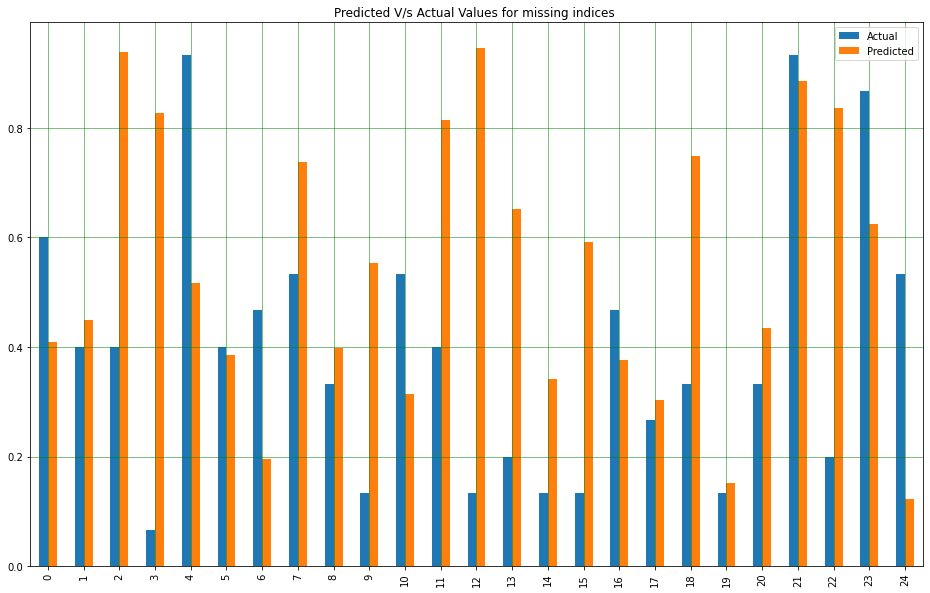

In [ ]:


df = pd.DataFrame({'Actual': target_test, 'Predicted':test_preds})
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Predicted V/s Actual Values for missing indices ',size=12)
plt.show()

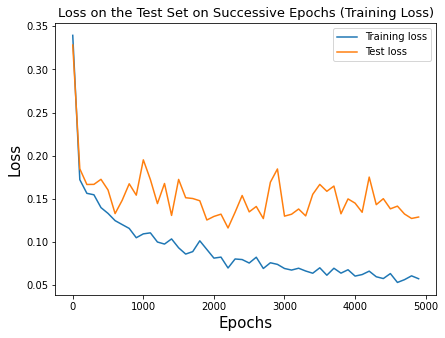

In [ ]:
# plotting the training loss
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot( [i * 100 for i in range(len(train_loss_1))],train_loss_1, label='Training loss')
plt.title('Loss on the Training Set on Successive Epochs',size= 13)
plt.legend()
plt.xlabel('Epochs',size= 15)
plt.ylabel('Loss',size=15)


plt.plot([i * 100 for i in range(len(train_loss_1))],test_loss_1, label='Test loss')
plt.title('Loss on the Test Set on Successive Epochs (Training Loss)',size= 13)
plt.legend()
plt.xlabel('Epochs',size= 15)
plt.ylabel('Loss',size=15)
plt.show()

## 1.5 Convert completed dataset to a dataframe and perform regression to predict the target column

In [ ]:
print(trainX.shape)
print(New_X_mb.shape)
out_mat = np.concatenate((trainX, New_X_mb), axis = 0)
print(out_mat.shape)

df_bc = pd.read_csv('breast.csv')
cols_names = df_bc.columns
df_imputed_bc = pd.DataFrame(data=out_mat,  columns=cols_names[:-1])

df_imputed_bc.head()

In [ ]:
# Imputed df = df_imputed_bs
# Original df = df_bc 
df_bc = df_bc[cols_names[:-1]]
df_bc.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,1,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,0.7859,3.0940,48.31,0.006240,0.01484,0.02813,0.010930,0.01397,0.002461,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,2,2,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,0.4690,1.1150,12.68,0.004731,0.01345,0.01652,0.005905,0.01619,0.002081,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,3,2,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,0.9480,2.1710,24.87,0.005332,0.02115,0.01536,0.011870,0.01522,0.002815,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472
3,4,2,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,0.9050,0.9975,11.36,0.002887,0.01285,0.01613,0.007308,0.01870,0.001972,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834
4,5,1,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0.2871,0.8937,1.8970,24.25,0.006532,0.02336,0.02905,0.012150,0.01743,0.003643,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790


In [ ]:
def cleaning_prediction(data_frame):
    y = df_imputed_bc.diagnosis                    
    list = ['id','diagnosis']
    x = df_imputed_bc.drop(list,axis = 1 )
    x.head()
cleaning_prediction(df_imputed_bc)

# 2  Statistical Impuation 


### 2.1 Imputing Values using statistical methods Overview

In statistics, imputation is the method of estimating missing values in a data set. There are a lot of different types of imputation, the result of the various types of datasets. On datasets with high percentages of missing values, some methods work better than others and vice versa. Our current focus is on numerical and boolean datsets.



1.   Expectation Maximization
2.  Mean Imputation
3.  Mode Imputation
4.  Median Imputation
5.  Random Imputation



### 2.2 Exploring Missingness

In [ ]:
df_bc = pd.read_csv('breast.csv')
list = ['Unnamed: 32']
df_bc = df_bc.drop(list,axis = 1 )
cols_names = df_bc.columns
df_bc.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,1,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,0.7859,3.0940,48.31,0.006240,0.01484,0.02813,0.010930,0.01397,0.002461,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,2,2,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,0.4690,1.1150,12.68,0.004731,0.01345,0.01652,0.005905,0.01619,0.002081,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,3,2,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,0.9480,2.1710,24.87,0.005332,0.02115,0.01536,0.011870,0.01522,0.002815,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472
3,4,2,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,0.9050,0.9975,11.36,0.002887,0.01285,0.01613,0.007308,0.01870,0.001972,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834
4,5,1,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0.2871,0.8937,1.8970,24.25,0.006532,0.02336,0.02905,0.012150,0.01743,0.003643,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790


In [ ]:
np_bc = df_bc.to_numpy()

In [ ]:
def binary_sampler(p, rows, cols):
  unif_random_matrix = np.random.uniform(0., 1., size = [rows, cols])
  binary_random_matrix = 1*(unif_random_matrix < p)
  return binary_random_matrix

def data_loader ( miss_rate):
  
  # Load data
  data_x = np_bc
 
  # Parameters
  no, dim = data_x.shape
  
  # Introduce missing data
  data_m = binary_sampler(1-miss_rate, no, dim)
  miss_data_x = data_x.copy()
  miss_data_x[data_m == 0] = np.nan
      
  return data_x, miss_data_x, data_m


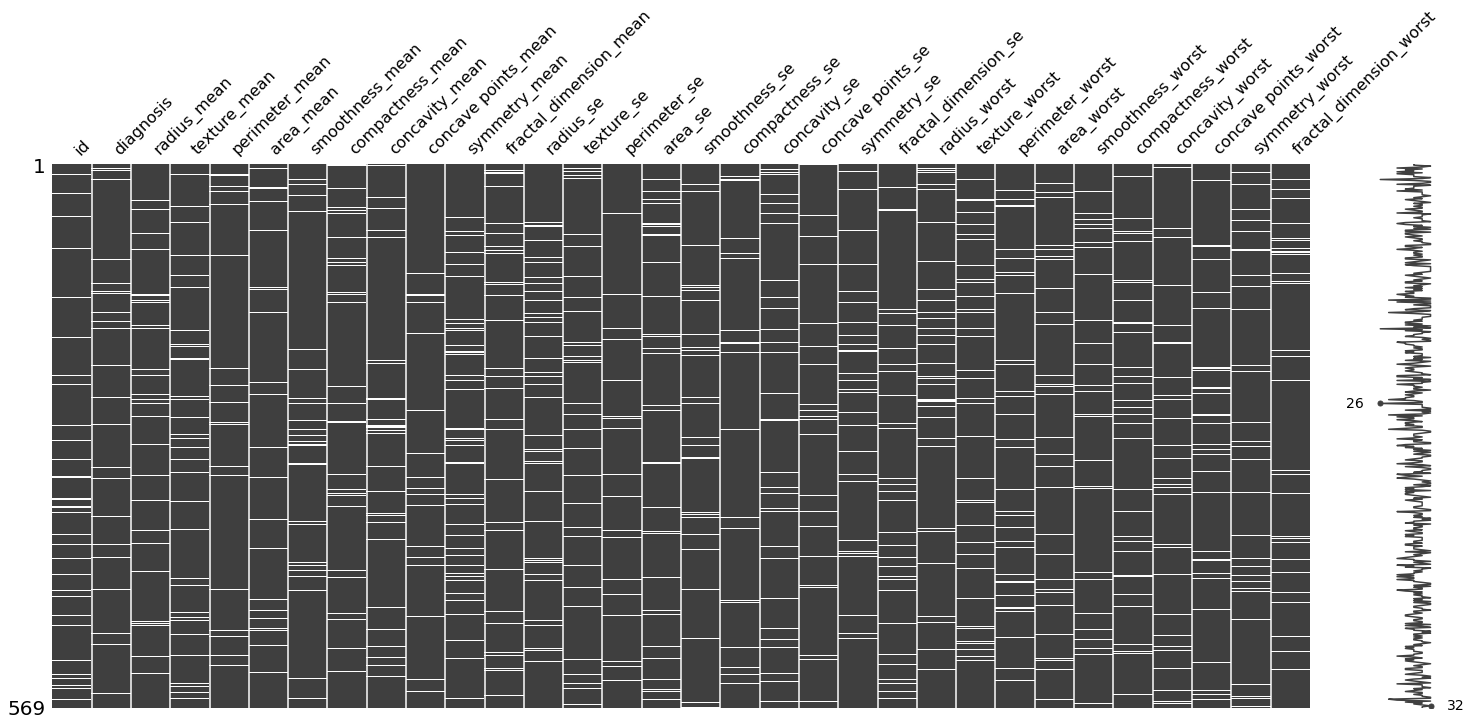

In [ ]:
# Introducing 5 % Missing Values 
data_x, miss_data_x, data_m = data_loader(0.05)
df_missing = pd.DataFrame(data=miss_data_x,  columns=cols_names)
msno.matrix(df_missing) 

<BarContainer object of 32 artists>

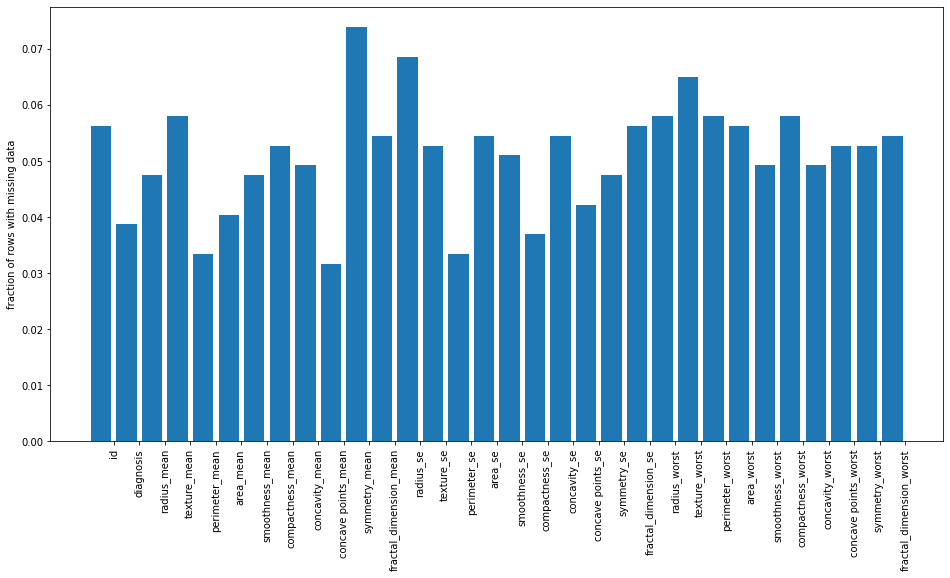

In [ ]:
import matplotlib as plt
import matplotlib.pyplot as plt
null_counts = df_missing.isnull().sum()/len(df_missing)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

In [ ]:
df_missing.isnull().sum()

id                         32
diagnosis                  22
radius_mean                27
texture_mean               33
perimeter_mean             19
area_mean                  23
smoothness_mean            27
compactness_mean           30
concavity_mean             28
concave points_mean        18
symmetry_mean              42
fractal_dimension_mean     31
radius_se                  39
texture_se                 30
perimeter_se               19
area_se                    31
smoothness_se              29
compactness_se             21
concavity_se               31
concave points_se          24
symmetry_se                27
fractal_dimension_se       32
radius_worst               33
texture_worst              37
perimeter_worst            33
area_worst                 32
smoothness_worst           28
compactness_worst          33
concavity_worst            28
concave points_worst       30
symmetry_worst             30
fractal_dimension_worst    31
dtype: int64

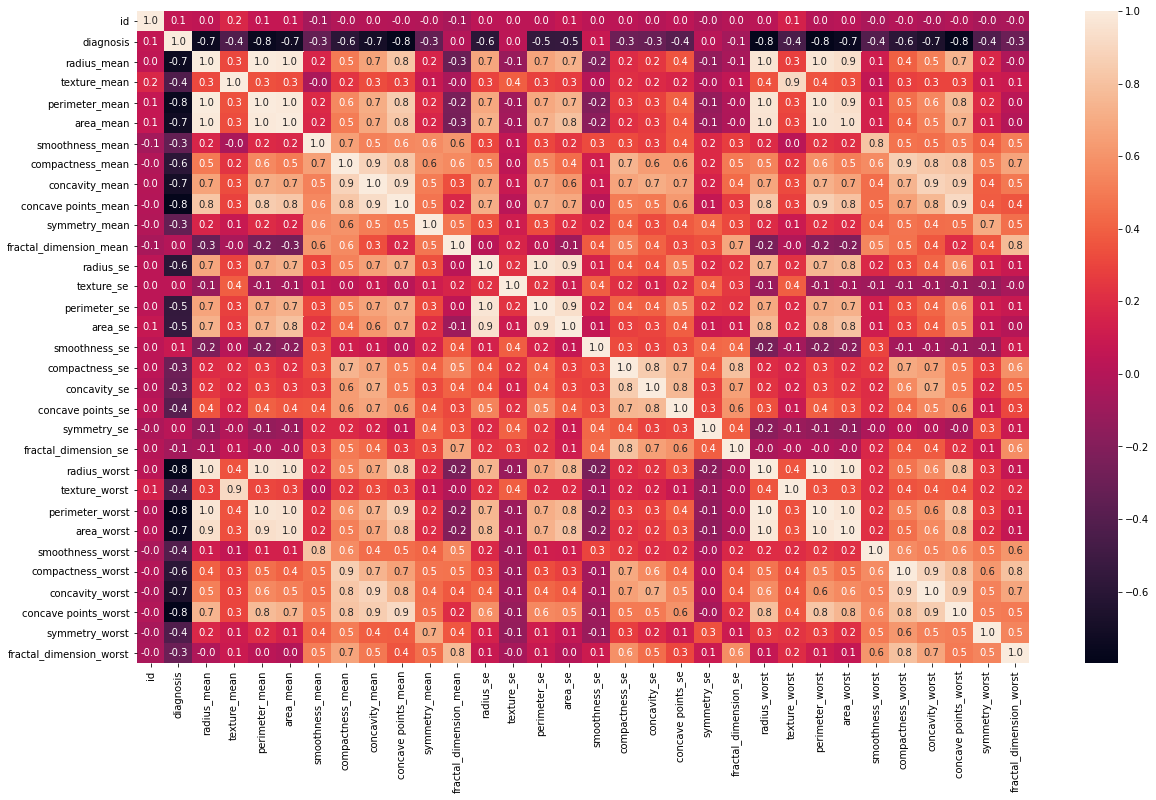

In [ ]:
plt.figure(figsize=(20,12))
sns.heatmap(df_missing.corr(),annot=True,fmt='.1f')
plt.show()

In [ ]:
!pip install impyute

In [ ]:
import impyute as impy
imputed_x = impy.mean(miss_data_x)

Cross Sectional Imputation
Imputations for cross-sectional data. Fill missing values in with a randomly selected value from the same column.